In [9]:
"""
Simon Wang

This project attempts to decode neuronal activity signals recorded from 196
neurons in the primary mortor cortex from a monkey's brain and maps these
signals into the monkey's hand movement.

This project also attempts to find, through K-fold validation, the optimal delay
time between neuronal activities and monkey's hand movement.

The data in this project comes from neural recordings described in:
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural
movement representations." Journal of neurophysiology 106.2 (2011): 764-774
https://journals.physiology.org/doi/full/10.1152/jn.00626.2010
"""

import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
from six.moves import urllib
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import sklearn.model_selection 
import tqdm.notebook

# load data
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'
if os.path.isfile(fn_dst):
  print('File %s is already downloaded' % fn_dst)
else:
  urllib.request.urlretrieve(fn_src, fn_dst)
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

tsamp = 0.05  # sampling time in seconds
nt = X.shape[0]
nneuron = X.shape[1]
nout = y.shape[1]
ttotal = nt*tsamp

# prepare training and testing data
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33)

File example_data_s1.pickle is already downloaded


In [10]:
# build and test memoryless linear model
linmod= linear_model.LinearRegression()
linmod.fit(Xtr, ytr)
yhat = linmod.predict(Xts)
rsq = r2_score(yts, yhat)
print('The RSQ value for linear model fit is ', rsq)

The RSQ value for linear model fit is  0.4648722700861733


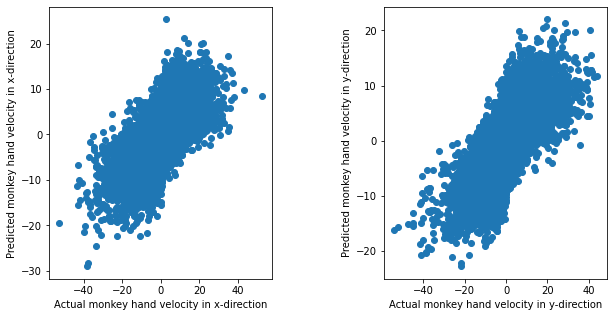

In [11]:
# visualize memeoryless model's result
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.scatter(yts[:, 0], yhat[:, 0])
ax1.set_xlabel('Actual monkey hand velocity in x-direction')
ax1.set_ylabel('Predicted monkey hand velocity in x-direction')
ax2.scatter(yts[:, 1], yhat[:, 1])
ax2.set_xlabel('Actual monkey hand velocity in y-direction')
ax2.set_ylabel('Predicted monkey hand velocity in y-direction')
plt.subplots_adjust(wspace=0.5)

In [12]:
# implement a function that generate a delay time between neuronal activities
# and monkey's hand movement
def create_dly_data(X,y,dly):
    """
    input: neuronal data X, y

    return: delayed neuronal data
            Xdly, ydly
    """
    # TODO
    n, p = X.shape
    Xdly = np.zeros([n-dly, 1])
    for i in range(0, p):
      curcol = X[:, i]
      for j in range(0, dly+1):
        curdlycol = curcol[j:j+n-dly, None]
        Xdly = np.hstack((Xdly, curdlycol))
    Xdly = Xdly[:, 1:(dly+1)*p+1]
    ydly = y[dly:n, :]
    return Xdly, ydly

In [13]:
# build and test linear model with consideration of delay
Xdly, ydly = create_dly_data(X, y, dly=6) # i.e. 6*tsamp = 6*0.05 = 0.3 second
Xtr_d6, Xts_d6, ytr_d6, yts_d6 = train_test_split(Xdly, ydly, test_size=0.33)
d6mod= linear_model.LinearRegression()
d6mod.fit(Xtr_d6, ytr_d6)
yhat_d6 = d6mod.predict(Xts_d6)
rsq_d6 = r2_score(yts_d6, yhat_d6)
print('The RSQ value for 6-unit delay model fit is ', rsq_d6)

The RSQ value for 6-unit delay model fit is  0.6902785139197455


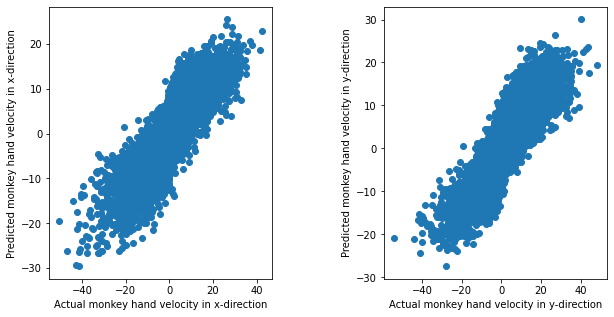

In [14]:
# visualize results of linear model with delay
plt.figure(figsize=(10,5))
ax3 = plt.subplot(121)
ax4 = plt.subplot(122)
ax3.scatter(yts_d6[:, 0], yhat_d6[:, 0])
ax3.set_xlabel('Actual monkey hand velocity in x-direction')
ax3.set_ylabel('Predicted monkey hand velocity in x-direction')
ax4.scatter(yts_d6[:, 1], yhat_d6[:, 1])
ax4.set_xlabel('Actual monkey hand velocity in y-direction')
ax4.set_ylabel('Predicted monkey hand velocity in y-direction')
plt.subplots_adjust(wspace=0.5)

In [15]:
# select a smaller portion of data for faster computation
nred = 6000
Xred = X[0:nred, :]
yred = y[0:nred, :]
nfold = 5  # Number of folds
dmax = 15  # maximum number of delays

kf = sklearn.model_selection.KFold(n_splits=nfold, shuffle=True)
dtest = np.arange(0, dmax+1)  
nd = len(dtest)
RSS = np.zeros([nd, nfold])

# create a progress bar
pbar = tqdm.notebook.tqdm(
    total=nfold*nd, initial=0,
    unit='fits', unit_divisor=nd, desc='Model order test')

for it, d in enumerate(dtest):
    Xdly, ydly = create_dly_data(Xred, yred, d)    
    rsq_sum = 0
    for isplit, Ind in enumerate(kf.split(Xdly)):
        Itr, Its = Ind        
        Xtr = Xdly[Itr]
        ytr = ydly[Itr]
        Xts = Xdly[Its]
        yts = ydly[Its] 
        regr = linear_model.LinearRegression()
        regr.fit(Xtr, ytr)
        yhat = regr.predict(Xts)
        rsq = r2_score(yts, yhat)
        RSS[d, isplit] = rsq
        pbar.update(1)
pbar.close()       

Text(0, 0.5, 'Testing RSQ')

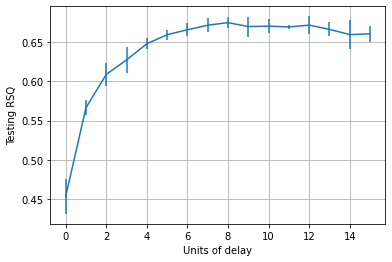

In [16]:
# visualize different delay units' effect on model accuracy
# to find delay as optimal
RSS_mean = np.mean(RSS, axis=1)
RSS_std = np.std(RSS, axis=1)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std)
plt.grid()
plt.xlabel('Units of delay')
plt.ylabel('Testing RSQ')

In [17]:
d_nr = np.argmax(RSS_mean)
print('The optimal delay should be ', dtest[d_nr])
print('Or ', dtest[d_nr]*tsamp, ' second. ')

The optimal delay should be  8
Or  0.4  second. 
